This notebook covers the use of the library to perform feature selection evaluated by cross-validation on a classification problem.

# Problem information

The "Adult" dataset, also known as the "Census Income" dataset, is used to predict whether an individual's income exceeds $50,000 per year based on various personal attributes. Here are the key details:

- Source: UCI Machine Learning Repository
- Number of Instances: 48,842
- Number of Attributes: 14, plus the target attribute (income) (These coded to dummy variables amount to a total of 97 variables.).

- Attributes:
    - Age
    - Workclass (e.g., Private, Self-emp-not-inc, etc.)
    - fnlwgt (final weight)
    - Education (e.g., Bachelors, HS-grad, etc.)
    - Education-Num (number of years of education)
    - Marital Status (e.g., Married-civ-spouse, Never-married, etc.)
    - Occupation (e.g., Tech-support, Craft-repair, etc.)
    - Relationship (e.g., Wife, Own-child, etc.)
    - Race (e.g., White, Black, etc.)
    - Sex (Male, Female)
    - Capital Gain
    - Capital Loss
    - Hours per week
    - Native Country (e.g., United-States, Mexico, etc.)
    - Target Attribute: Income (binary classification: <=50K or >50K)


__IMPORTANT INFORMATION__

- The problem has been planted as a minimization.
- The internal model was evaluated via cross-validation.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# used libraries
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import pywinEA2

In [2]:
def getDataset() -> pd.DataFrame:
    """ Create the testing dataset """
    adult = fetch_openml(name='adult', version=2)
    df = pd.DataFrame(adult.data, columns=adult.feature_names)
    df['target'] = adult.target

    # codify dummy variables
    df = pd.get_dummies(df, drop_first=True)

    return df

In [3]:
data = getDataset()
data.head(5)

/home/fgarcia/anaconda3/envs/mlv0/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,target_>50K
0,25.0,226802.0,7.0,0.0,0.0,40.0,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1,38.0,89814.0,9.0,0.0,0.0,50.0,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,28.0,336951.0,12.0,0.0,0.0,40.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,44.0,160323.0,10.0,7688.0,0.0,40.0,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
4,18.0,103497.0,10.0,0.0,0.0,30.0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


## Baseline model

Evaluation of the model using all features by 5-fold cross-validation. F1-score is reported.

In [4]:
model = DecisionTreeClassifier(
    max_depth=10,
    max_features='sqrt',
    random_state=1997
)
cv_baseline = cross_val_score(
    model,
    X=data.drop(columns=['target_>50K']),
    y=data['target_>50K'],
    scoring='f1',
    cv=5
)

print('Average f1-score: {:.3f} +/- {:.3f}'.format(np.mean(cv_baseline), np.std(cv_baseline)))

Average f1-score: 0.562 +/- 0.011


## Genetic algorithms for feature selection

In this part of the notebook, two different algorithms are tested to perform feature selection. On one side a basic genetic algorithm with elitism and on the other side the NSGAII. In both algorithms the F1-score obtained on the test set of a 5-fold cross-validation will be maximized. In NSGAII, the second objective will consist of a minimization of the number of features.

In [5]:
target_features = data.drop(columns=['target_>50K']).columns.tolist()

### Mono-objective GAs (MoGAs)

In [6]:
# mono-objetive genetic algorithm (MoGA) definition (genetic algorithm operators left as default)
moga = pywinEA2.FeatureSelectionGA(
    # data-related parameters
    data=data,
    model=DecisionTreeClassifier(
        max_depth=10,
        max_features='sqrt',
        random_state=1997
    ),
    score=f1_score,                          # also 'f1' provided as string could work
    y=['target_>50K'],                       # target variable (must be present in the data)
    population_size=100,
    max_generations=100,
    optim='max',
    # ... subject all variables except the 'target' variable to the feture selection
    target_feats=target_features,  
    
    # cross-validation parameters used for evaluate the inner model
    cv=5,
    cv_reps=1,
    stratified=True,
)

In [7]:
# run the MoGA algorithm with elitism (elite size 10) 
# this may take a while...
moga_report = pywinEA2.run(moga, type='eaSimpleWithElitism', hof_size=10, verbose=True)

gen	nevals	avg     	std      	min     	max     	sum    
0  	100   	0.475485	0.0912678	0.132016	0.631849	47.5485
1  	55    	0.523945	0.0621916	0.32062 	0.631849	52.3945
2  	52    	0.548847	0.0540751	0.366501	0.631849	54.8847
3  	60    	0.560187	0.0523984	0.38174 	0.631849	56.0187
4  	49    	0.578932	0.0384656	0.465604	0.632645	57.8932
5  	42    	0.59003 	0.0380802	0.431026	0.632916	59.003 
6  	58    	0.589019	0.0442303	0.431719	0.638933	58.9019
7  	51    	0.59055 	0.0382781	0.4962  	0.638933	59.055 
8  	51    	0.590469	0.0472832	0.409232	0.642564	59.0469
9  	51    	0.604721	0.0378908	0.441534	0.642564	60.4721
10 	58    	0.604361	0.0393603	0.393759	0.645853	60.4361
11 	53    	0.608353	0.0428139	0.301453	0.645853	60.8353
12 	65    	0.60709 	0.0303688	0.522992	0.645853	60.709 
13 	48    	0.609779	0.0336334	0.491733	0.645853	60.9779
14 	52    	0.607801	0.0371941	0.44404 	0.645853	60.7801
15 	49    	0.609206	0.0356358	0.508174	0.645853	60.9206
16 	53    	0.612138	0.0381896	0.455185	0.645853	

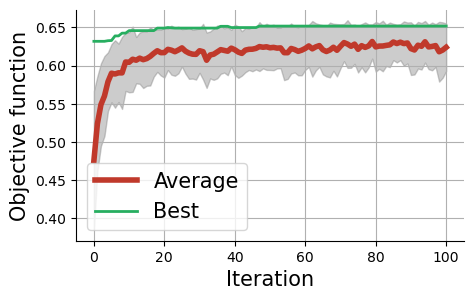

In [8]:
# display model convergence
pywinEA2.report.displayConvergence(
    moga_report,
    figsize=(5, 3),
)

In [9]:
# evaluate the performance of the model 
for ind in moga_report.hall_of_fame:
    selected_features = np.array(target_features)[np.array(ind, dtype=bool)]
    cv_scores = cross_val_score(
        model,
        X=data[selected_features],
        y=data['target_>50K'],
        scoring='f1',
        cv=5
    )
    print('Average f1-score (number of features {} [{:.1f}%]): {:.3f} +/- {:.3f}'.format(
        len(selected_features), len(selected_features) / (data.shape[1] - 1) * 100,
        np.mean(cv_scores), np.std(cv_scores)))

Average f1-score (number of features 49 [50.5%]): 0.640 +/- 0.012
Average f1-score (number of features 49 [50.5%]): 0.634 +/- 0.006
Average f1-score (number of features 49 [50.5%]): 0.632 +/- 0.009
Average f1-score (number of features 49 [50.5%]): 0.623 +/- 0.026
Average f1-score (number of features 49 [50.5%]): 0.639 +/- 0.009
Average f1-score (number of features 49 [50.5%]): 0.639 +/- 0.007
Average f1-score (number of features 49 [50.5%]): 0.639 +/- 0.016
Average f1-score (number of features 49 [50.5%]): 0.639 +/- 0.014
Average f1-score (number of features 44 [45.4%]): 0.609 +/- 0.054
Average f1-score (number of features 48 [49.5%]): 0.611 +/- 0.050


### Multi-objective GAs (MuGAs)

In [10]:
# mono-objetive genetic algorithm (MoGA) definition (genetic algorithm operators left as default)
muga = pywinEA2.MultiObjFeatureSelectionNSGA2(
    # data-related parameters
    data=data,
    model=DecisionTreeClassifier(
        max_depth=10,
        max_features='sqrt',
        random_state=1997
    ),
    score='f1',                              # also 'f1' provided as string could work
    y=['target_>50K'],                       # target variable (must be present in the data)
    population_size=100,
    max_generations=100,
    optim='max',
    # ... subject all variables except the 'target' variable to the feture selection
    target_feats=target_features,  
    
    # cross-validation parameters used for evaluate the inner model
    cv=5,
    cv_reps=1,
    stratified=True,
)

/home/fgarcia/anaconda3/envs/mlv0/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/fgarcia/anaconda3/envs/mlv0/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [11]:
# The latest version of deap (base library of genetic algorithms used to build pywinEA2) throws a very annoying warning when calculating the 
# hypervolume. Silence it
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    muga_report = pywinEA2.run(muga, type='nsga2', verbose=True)

gen	nevals	avg    	std    	min      	max	sum    	multiobj_fitness_values_mean	multiobj_fitness_values_min	multiobj_fitness_values_max
0  	      	24.2924	24.0019	0.0860985	60 	4858.49	[ 0.48488029 48.1       ]   	[ 0.08609851 37.        ]  	[ 0.59848369 60.        ]  
1  	      	23.426 	23.1896	0.200344 	60 	4685.19	[ 0.53193033 46.32      ]   	[ 0.20034443 37.        ]  	[ 0.61688411 60.        ]  
2  	      	22.806 	22.6562	0.229789 	59 	4561.19	[ 0.54194901 45.07      ]   	[ 0.22978901 37.        ]  	[ 0.61688411 59.        ]  
3  	      	22.8373	22.7029	0.2398   	59 	4567.46	[ 0.5746195 45.1      ]     	[ 0.23980005 34.        ]  	[ 0.63530462 59.        ]  
4  	      	22.5813	22.3845	0.2398   	56 	4516.26	[ 0.58257971 44.58      ]   	[ 0.23980005 31.        ]  	[ 0.63530462 56.        ]  
5  	      	21.8952	21.8112	0.2398   	56 	4379.03	[ 0.58032904 43.21      ]   	[ 0.23980005 31.        ]  	[ 0.63530462 56.        ]  
6  	      	22.6799	22.652 	0.416912 	56 	4535.97	[ 0.59970314 

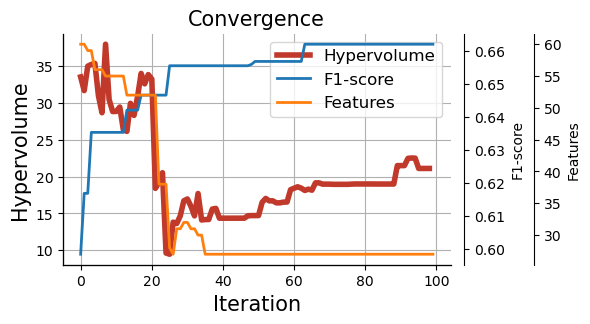

In [12]:
pywinEA2.report.displayMultiObjectiveConvergence(
    muga_report,
    title='Convergence', 
    objective_names=['F1-score', 'Features'],
    figsize=(5, 3),
    title_size=15,
    legend_size=12
)

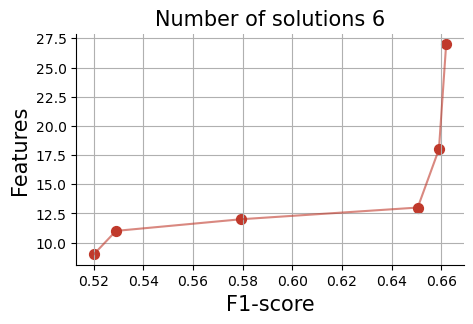

In [13]:
pywinEA2.report.displayParetoFront(
    muga_report,
    objective_names=['Features', 'F1-score'],
    figsize=(5, 3),
    title_size=15
)

In [14]:
# evaluate the performance of the model using the pareto front
for ind in muga_report.pareto_front:
    selected_features = np.array(target_features)[np.array(ind, dtype=bool)]
    cv_scores = cross_val_score(
        model,
        X=data[selected_features],
        y=data['target_>50K'],
        scoring='f1',
        cv=5
    )
    print('Average f1-score (number of features {} [{:.1f}%]): {:.3f} +/- {:.3f}'.format(
        len(selected_features), len(selected_features) / (data.shape[1] - 1) * 100,
        np.mean(cv_scores), np.std(cv_scores)))

Average f1-score (number of features 27 [27.8%]): 0.650 +/- 0.013
Average f1-score (number of features 18 [18.6%]): 0.646 +/- 0.011
Average f1-score (number of features 13 [13.4%]): 0.622 +/- 0.031
Average f1-score (number of features 12 [12.4%]): 0.581 +/- 0.022
Average f1-score (number of features 11 [11.3%]): 0.526 +/- 0.011
Average f1-score (number of features 9 [9.3%]): 0.477 +/- 0.022
